In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler


In [16]:
df_V1=pd.read_csv("Data/Preprocessed/Rockburst_in_Tunnel_V1.csv")
df_V2=pd.read_csv("Data/Preprocessed/Rockburst_in_Tunnel_V2.csv")
df_V3=pd.read_csv("Data/Preprocessed/Rockburst_in_Tunnel_V3.csv")

In [17]:
df_V1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91 entries, 0 to 90
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Energy_Unit              91 non-null     int64  
 1   Energy_density_Joule     91 non-null     float64
 2   Volume_m3                91 non-null     float64
 3   Event_freq_unit_per_day  91 non-null     float64
 4   Energy_Joule_per_day     91 non-null     float64
 5   Volume_m3_per_day        91 non-null     float64
 6   Duration_days            91 non-null     float64
 7   Intensity_Level          91 non-null     object 
 8   Intensity_Level_encoded  91 non-null     int64  
 9   Energy_per_Volume        91 non-null     float64
dtypes: float64(7), int64(2), object(1)
memory usage: 7.2+ KB


In [18]:
df_V2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91 entries, 0 to 90
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Energy_Unit                  91 non-null     int64  
 1   Energy_density_Joule         91 non-null     float64
 2   Volume_m3                    91 non-null     float64
 3   Event_freq_unit_per_day      91 non-null     float64
 4   Energy_Joule_per_day         91 non-null     float64
 5   Volume_m3_per_day            91 non-null     float64
 6   Duration_days                91 non-null     float64
 7   Intensity_Level              91 non-null     object 
 8   Intensity_Level_encoded      91 non-null     int64  
 9   Energy_per_Volume            91 non-null     float64
 10  Energy_Unit_log              91 non-null     float64
 11  Energy_density_Joule_sqr     91 non-null     float64
 12  Volume_m3_sqr                91 non-null     float64
 13  Event_freq_unit_per_da

In [19]:
df_V3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Unnamed: 0                   1000 non-null   int64  
 1   Duration_days                1000 non-null   float64
 2   Energy_Unit_log              1000 non-null   float64
 3   Energy_density_Joule_sqr     1000 non-null   float64
 4   Volume_m3_sqr                1000 non-null   float64
 5   Event_freq_unit_per_day_log  1000 non-null   float64
 6   Energy_Joule_per_day_sqr     1000 non-null   float64
 7   Volume_m3_per_day_sqr        1000 non-null   float64
 8   Energy_per_Volume_log        1000 non-null   float64
 9   Intensity_Level_encoded      1000 non-null   int64  
dtypes: float64(8), int64(2)
memory usage: 78.3 KB


In [20]:
exclude_cols = ["Intensity_Level","Intensity_Level_encoded"]           
features_V1 = [col for col in df_V1.columns if col not in exclude_cols]

In [21]:
def train_models(df, dataset_name,features):
    # 1. Features & Target
    X = df[features]
    y = df['Intensity_Level_encoded']

    # Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    scaler=StandardScaler()
    X_train_scaled=scaler.fit_transform(X_train)
    X_test_scaled=scaler.fit_transform(X_test)

    # 2. Models
    models = {
        "Logistic Regression": LogisticRegression(max_iter=5000),
        "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
        "SVM": SVC(kernel='rbf', probability=True, random_state=42),
        "XGBoost": XGBClassifier(eval_metric='mlogloss', random_state=42)
    }

    results = {}

    # 3. Training & Evaluation
    for name, model in models.items():
        model.fit(X_train_scaled, y_train)
        preds = model.predict(X_test_scaled)
        acc = accuracy_score(y_test, preds)
        results[name] = acc

        print(f"\n=== {dataset_name} | {name} ===")
        print("Accuracy:", round(acc, 4))
        print("Classification Report:\n", classification_report(y_test, preds))

        # Confusion Matrix
        cm = confusion_matrix(y_test, preds)
        plt.figure(figsize=(5,4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=np.unique(y),
                    yticklabels=np.unique(y))
        plt.title(f"{dataset_name} - {name} | Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.show()

    # Accuracy Comparison
    plt.figure(figsize=(8,5))
    models_name=list(results.keys())
    performance=list(results.values())
    sns.barplot(x=models_name, y=performance, palette='viridis',hue=models_name,legend=False)
    plt.ylabel("Accuracy")
    plt.title("Model Accuracy Comparison")
    plt.ylim(0, 1)
    plt.show()
    models_df = pd.DataFrame({
        "Model": models_name,
        "Accuracy": performance
    })

    return models_df,models,scaler



=== RockBurst V1 | Logistic Regression ===
Accuracy: 0.5789
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.57      0.67         7
           1       0.25      0.20      0.22         5
           2       0.56      1.00      0.71         5
           3       1.00      0.50      0.67         2

    accuracy                           0.58        19
   macro avg       0.65      0.57      0.57        19
weighted avg       0.61      0.58      0.56        19



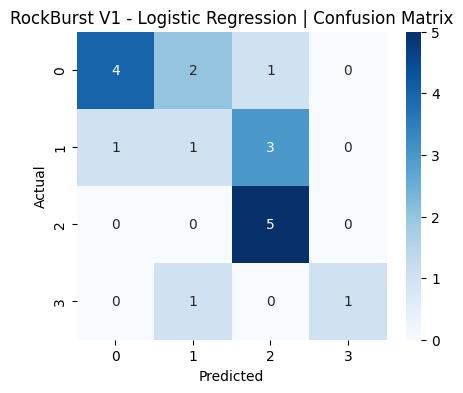


=== RockBurst V1 | Random Forest ===
Accuracy: 0.6316
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.57      0.67         7
           1       0.50      0.60      0.55         5
           2       0.57      0.80      0.67         5
           3       1.00      0.50      0.67         2

    accuracy                           0.63        19
   macro avg       0.72      0.62      0.64        19
weighted avg       0.68      0.63      0.63        19



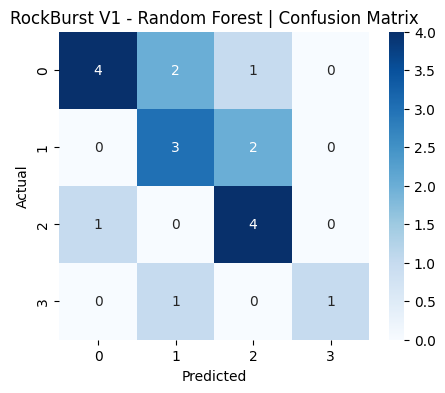


=== RockBurst V1 | SVM ===
Accuracy: 0.6316
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.71      0.77         7
           1       0.33      0.20      0.25         5
           2       0.56      1.00      0.71         5
           3       1.00      0.50      0.67         2

    accuracy                           0.63        19
   macro avg       0.68      0.60      0.60        19
weighted avg       0.65      0.63      0.61        19



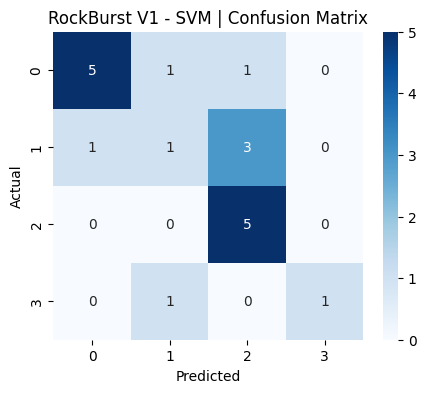


=== RockBurst V1 | XGBoost ===
Accuracy: 0.5263
Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.57      0.57         7
           1       0.40      0.40      0.40         5
           2       0.50      0.60      0.55         5
           3       1.00      0.50      0.67         2

    accuracy                           0.53        19
   macro avg       0.62      0.52      0.55        19
weighted avg       0.55      0.53      0.53        19



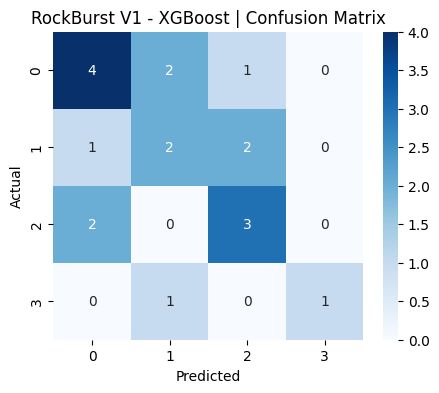

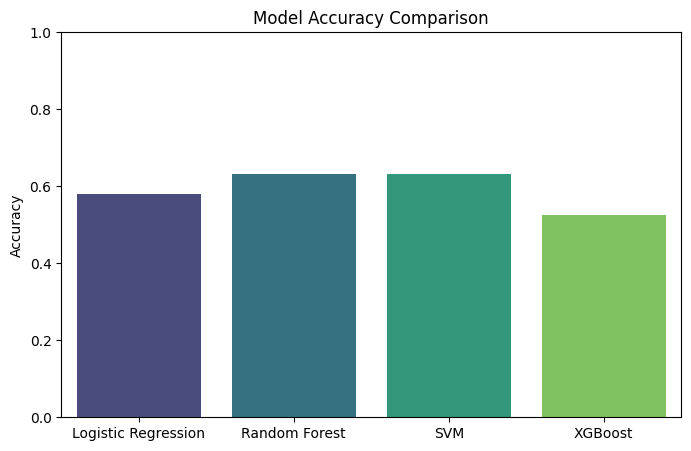

In [22]:
results_df_V1,models_V1,scaler_V1=train_models(df_V1,"RockBurst V1",features_V1)

In [23]:
results_df_V1.sort_values(by="Accuracy",ascending=False)

,Model,Accuracy
1,Random Forest,0.631579
2,SVM,0.631579
0,Logistic Regression,0.578947
3,XGBoost,0.526316


In [24]:
df_V2.columns

Index(['Energy_Unit', 'Energy_density_Joule', 'Volume_m3',
       'Event_freq_unit_per_day', 'Energy_Joule_per_day', 'Volume_m3_per_day',
       'Duration_days', 'Intensity_Level', 'Intensity_Level_encoded',
       'Energy_per_Volume', 'Energy_Unit_log', 'Energy_density_Joule_sqr',
       'Volume_m3_sqr', 'Event_freq_unit_per_day_log',
       'Energy_Joule_per_day_sqr', 'Volume_m3_per_day_sqr',
       'Energy_per_Volume_log'],
      dtype='object')

In [25]:
exclude_cols = ['Energy_Unit', 'Energy_density_Joule', 'Volume_m3',
       'Event_freq_unit_per_day', 'Energy_Joule_per_day', 'Volume_m3_per_day',
       "Intensity_Level","Intensity_Level_encoded",'Energy_per_Volume']           
features_V2 = [col for col in df_V2.columns if col not in exclude_cols]

In [26]:
features_V2

['Duration_days',
 'Energy_Unit_log',
 'Energy_density_Joule_sqr',
 'Volume_m3_sqr',
 'Event_freq_unit_per_day_log',
 'Energy_Joule_per_day_sqr',
 'Volume_m3_per_day_sqr',
 'Energy_per_Volume_log']


=== RockBurst V2 | Logistic Regression ===
Accuracy: 0.5263
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.57      0.67         7
           1       0.17      0.20      0.18         5
           2       0.57      0.80      0.67         5
           3       1.00      0.50      0.67         2

    accuracy                           0.53        19
   macro avg       0.63      0.52      0.55        19
weighted avg       0.59      0.53      0.54        19



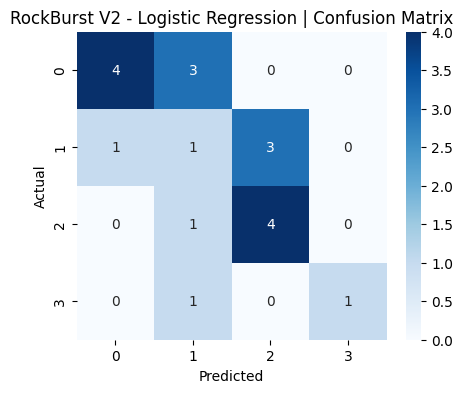


=== RockBurst V2 | Random Forest ===
Accuracy: 0.5789
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.57      0.67         7
           1       0.40      0.40      0.40         5
           2       0.50      0.80      0.62         5
           3       1.00      0.50      0.67         2

    accuracy                           0.58        19
   macro avg       0.68      0.57      0.59        19
weighted avg       0.64      0.58      0.58        19



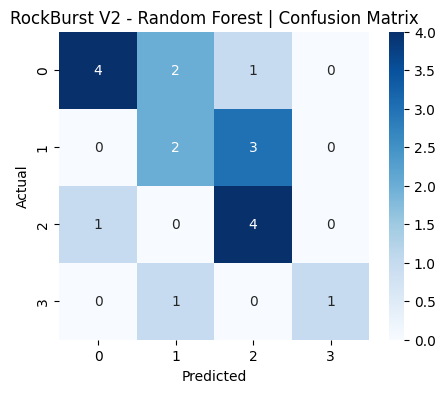


=== RockBurst V2 | SVM ===
Accuracy: 0.5789
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.71      0.77         7
           1       0.25      0.20      0.22         5
           2       0.50      0.80      0.62         5
           3       1.00      0.50      0.67         2

    accuracy                           0.58        19
   macro avg       0.65      0.55      0.57        19
weighted avg       0.61      0.58      0.57        19



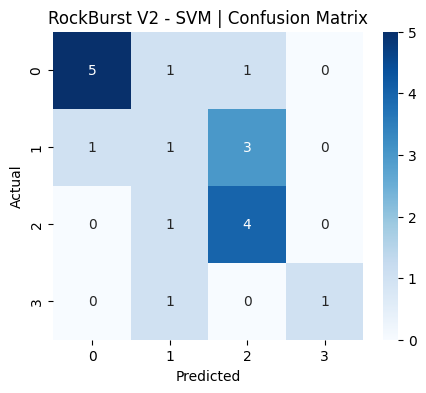


=== RockBurst V2 | XGBoost ===
Accuracy: 0.5789
Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.57      0.62         7
           1       0.50      0.60      0.55         5
           2       0.50      0.60      0.55         5
           3       1.00      0.50      0.67         2

    accuracy                           0.58        19
   macro avg       0.67      0.57      0.59        19
weighted avg       0.61      0.58      0.58        19



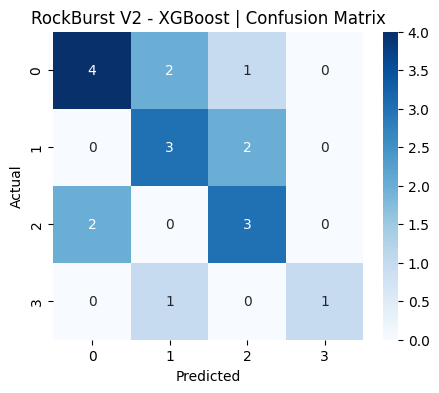

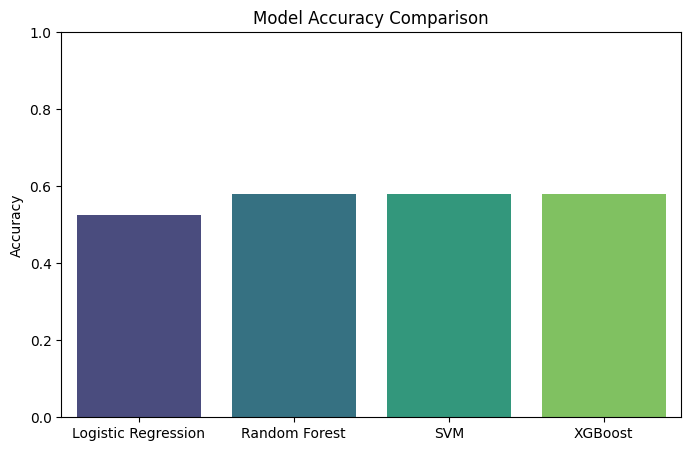

In [27]:
results_df_V2,models_V2,scaler_V2=train_models(df_V2,"RockBurst V2",features_V2)

In [28]:
results_df_V2.sort_values(by="Accuracy",ascending=False)

,Model,Accuracy
1,Random Forest,0.578947
2,SVM,0.578947
3,XGBoost,0.578947
0,Logistic Regression,0.526316


In [29]:
df_V3.columns

Index(['Unnamed: 0', 'Duration_days', 'Energy_Unit_log',
       'Energy_density_Joule_sqr', 'Volume_m3_sqr',
       'Event_freq_unit_per_day_log', 'Energy_Joule_per_day_sqr',
       'Volume_m3_per_day_sqr', 'Energy_per_Volume_log',
       'Intensity_Level_encoded'],
      dtype='object')

In [30]:
df_V3.tail()

,Unnamed: 0,Duration_days,Energy_Unit_log,Energy_density_Joule_sqr,Volume_m3_sqr,Event_freq_unit_per_day_log,Energy_Joule_per_day_sqr,Volume_m3_per_day_sqr,Energy_per_Volume_log,Intensity_Level_encoded
995,995,10.961892,3.744226,35.551198,22.101972,1.552680,24.185248,13.304769,2.264111,3
996,996,5.973271,2.637072,19.382871,19.625581,1.152048,13.079608,13.289764,1.366179,1
997,997,4.044154,1.619045,21.234970,13.677697,0.693711,15.901132,9.702540,0.747772,1
998,998,1.976988,1.098587,3.766872,10.496657,0.691412,2.777449,8.663901,0.480834,0
999,999,10.010743,3.907413,37.724586,25.989094,1.928437,26.530561,17.287990,2.364591,3


In [31]:
exclude_cols = ['Unnamed: 0','Intensity_Level_encoded']           
features_V3 = [col for col in df_V3.columns if col not in exclude_cols]

In [32]:
features_V3

['Duration_days',
 'Energy_Unit_log',
 'Energy_density_Joule_sqr',
 'Volume_m3_sqr',
 'Event_freq_unit_per_day_log',
 'Energy_Joule_per_day_sqr',
 'Volume_m3_per_day_sqr',
 'Energy_per_Volume_log']


=== RockBurst V3 | Logistic Regression ===
Accuracy: 0.86
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.82      0.82        51
           1       0.73      0.76      0.75        50
           2       0.90      0.86      0.88        50
           3       1.00      1.00      1.00        49

    accuracy                           0.86       200
   macro avg       0.86      0.86      0.86       200
weighted avg       0.86      0.86      0.86       200



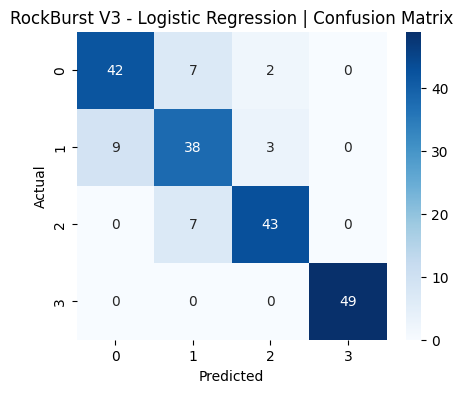


=== RockBurst V3 | Random Forest ===
Accuracy: 0.995
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99        51
           1       0.98      1.00      0.99        50
           2       1.00      1.00      1.00        50
           3       1.00      1.00      1.00        49

    accuracy                           0.99       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      0.99      0.99       200



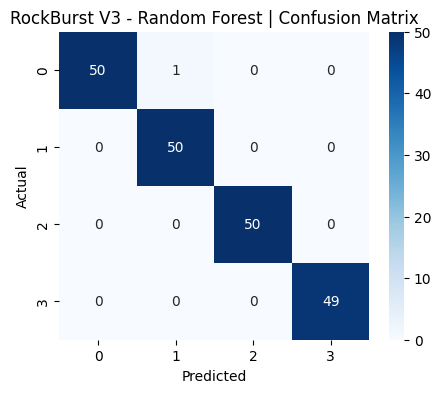


=== RockBurst V3 | SVM ===
Accuracy: 0.905
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.76      0.83        51
           1       0.81      0.88      0.85        50
           2       0.91      0.98      0.94        50
           3       1.00      1.00      1.00        49

    accuracy                           0.91       200
   macro avg       0.91      0.91      0.90       200
weighted avg       0.91      0.91      0.90       200



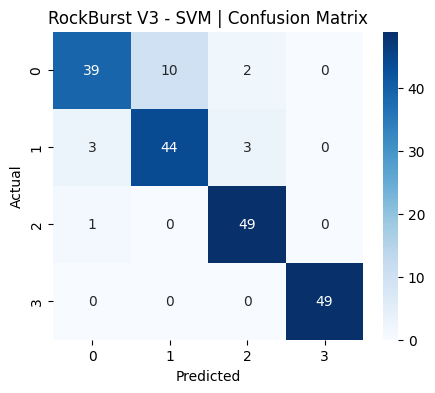


=== RockBurst V3 | XGBoost ===
Accuracy: 0.965
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.96      0.95        51
           1       0.96      0.90      0.93        50
           2       0.96      1.00      0.98        50
           3       1.00      1.00      1.00        49

    accuracy                           0.96       200
   macro avg       0.97      0.97      0.96       200
weighted avg       0.97      0.96      0.96       200



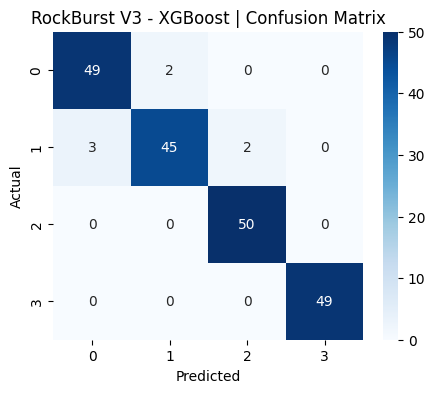

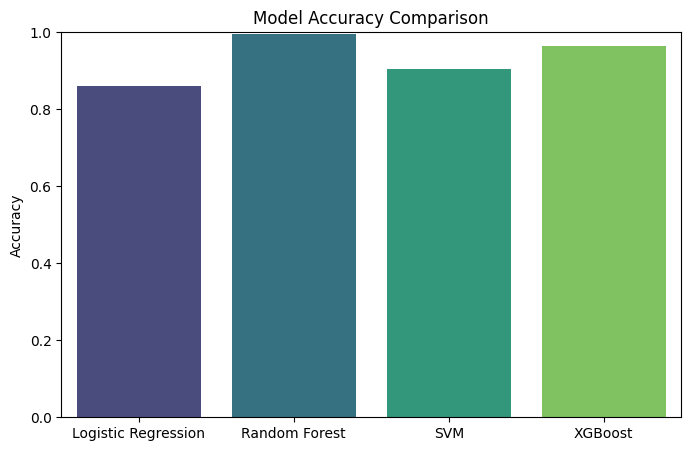

In [33]:
results_df_V3,models_V3,scaler_V3=train_models(df_V3,"RockBurst V3",features_V3)

In [34]:
results_df_V3.sort_values(by="Accuracy",ascending=False)

,Model,Accuracy
1,Random Forest,0.995
3,XGBoost,0.965
2,SVM,0.905
0,Logistic Regression,0.860


In [35]:
results_df_V1['Version'] = 'V1'
results_df_V2['Version'] = 'V2'
results_df_V3['Version'] = 'V3'

results_df_all = pd.concat([results_df_V1, results_df_V2, results_df_V3], ignore_index=True)


In [36]:
results_df_all

,Model,Accuracy,Version
0,Logistic Regression,0.578947,V1
1,Random Forest,0.631579,V1
2,SVM,0.631579,V1
3,XGBoost,0.526316,V1
4,Logistic Regression,0.526316,V2
5,Random Forest,0.578947,V2
6,SVM,0.578947,V2
7,XGBoost,0.578947,V2
8,Logistic Regression,0.860000,V3
9,Random Forest,0.995000,V3


In [37]:
df_wide = results_df_all.pivot(index='Model', columns='Version', values='Accuracy')

In [38]:
df_wide.reindex()

Version,V1,V2,V3
Model,,,
Logistic Regression,0.578947,0.526316,0.860
Random Forest,0.631579,0.578947,0.995
SVM,0.631579,0.578947,0.905
XGBoost,0.526316,0.578947,0.965


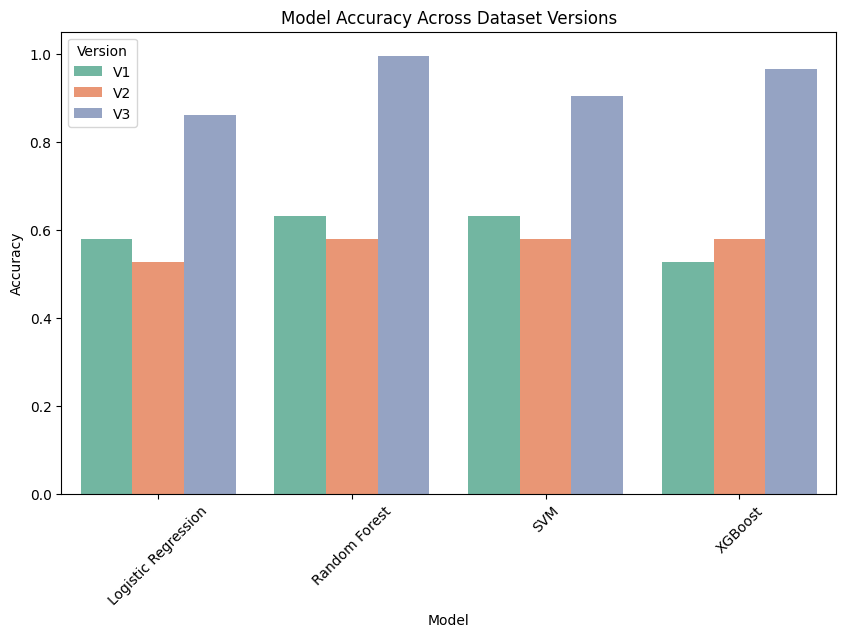

In [39]:
plt.figure(figsize=(10,6))
sns.barplot(data=results_df_all, x="Model", y="Accuracy", hue="Version", palette="Set2")
plt.title("Model Accuracy Across Dataset Versions")
plt.ylim(0, 1.05)
plt.xticks(rotation=45)
plt.show()


# Saving Best Model

In [40]:
print(type(models_V3))


<class 'dict'>


In [41]:
import joblib

# Save model + features list
joblib.dump((models_V3["XGBoost"], features_V3), "trained_models/xgboost_model_V3.pkl")
joblib.dump((models_V3["Random Forest"],features_V3), "trained_models/Random_Forest_model_V3.pkl")
joblib.dump((models_V3["SVM"],features_V3), "trained_models/SVM_model_V3.pkl")

# Saving Scaler of V3
joblib.dump(scaler_V3, "trained_models/scaler_V3.pkl")


['trained_models/scaler_V3.pkl']

# Applying Cross Validation to check overfitting of best models 

In [42]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

X = df_V3[features_V3]
y = df_V3["Intensity_Level_encoded"]

In [43]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=5000),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "SVM": SVC(kernel='rbf', probability=True, random_state=42),
    "XGBoost": XGBClassifier(eval_metric='mlogloss', random_state=42)
}

# Stratified K-Fold CV
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("Version 3 Cross-Validation Results")
for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=skf, scoring='accuracy')
    print(f"{name}: Mean Acc = {np.mean(scores):.4f}, Std Dev = {np.std(scores):.4f}, Folds = {scores}")


Version 3 Cross-Validation Results
Logistic Regression: Mean Acc = 0.8830, Std Dev = 0.0169, Folds = [0.915 0.88  0.88  0.865 0.875]
Random Forest: Mean Acc = 1.0000, Std Dev = 0.0000, Folds = [1. 1. 1. 1. 1.]
SVM: Mean Acc = 0.8390, Std Dev = 0.0080, Folds = [0.845 0.83  0.85  0.84  0.83 ]
XGBoost: Mean Acc = 0.9940, Std Dev = 0.0058, Folds = [1.    0.995 0.985 0.99  1.   ]


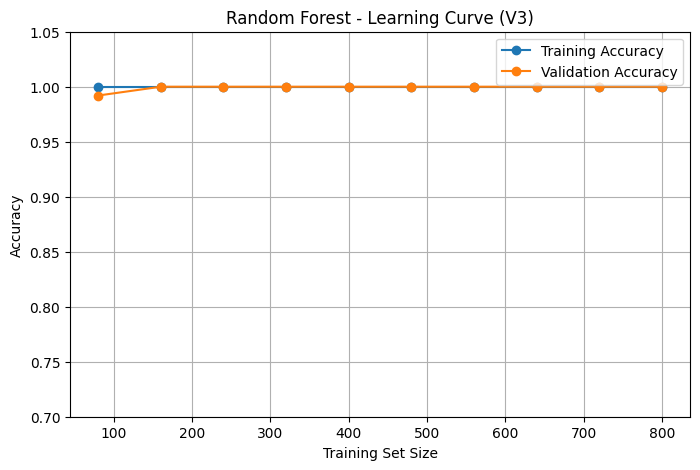

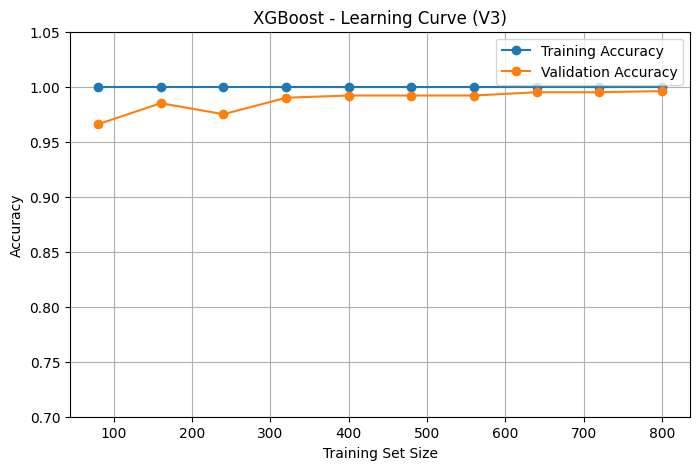

In [44]:
from sklearn.model_selection import learning_curve

#Learning curve function 
def plot_learning_curve(estimator, X, y, title):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=5, scoring='accuracy', n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10), random_state=42
    )
    train_mean = np.mean(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)

    plt.figure(figsize=(8, 5))
    plt.plot(train_sizes, train_mean, 'o-', label="Training Accuracy")
    plt.plot(train_sizes, test_mean, 'o-', label="Validation Accuracy")
    plt.title(title)
    plt.xlabel("Training Set Size")
    plt.ylabel("Accuracy")
    plt.ylim(0.7, 1.05)
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot curves 
plot_learning_curve(RandomForestClassifier(n_estimators=200, random_state=42),
                    X, y, "Random Forest - Learning Curve (V3)")

plot_learning_curve(XGBClassifier(eval_metric='mlogloss', random_state=42),
                    X, y, "XGBoost - Learning Curve (V3)")


# There is no overfitting in models as our data is so strong coorelated and balanced that model generalized very well